# **UTILS**

In [ ]:
import os


!unzip /content/drive/MyDrive/img_resized.zip
!unzip /content/drive/MyDrive/img_txt.zip
print(len(os.listdir('/content/img_resized')))
print(len(os.listdir('/content/img_txt')))
!cp /content/drive/MyDrive/hate_speech/hate_speech_data/MMHS150K_GT.json /content

# **DEPENDENCIES**

In [ ]:
!pip install easyocr tqdm

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import pandas as pd
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F
import torch.optim as optim
import re
from PIL import Image
from torchtext.vocab import GloVe
from torch.utils.data import random_split
import easyocr
import cv2
import json
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.metrics import f1_score, roc_auc_score
from torch.nn.utils.rnn import pad_sequence
import random
from tqdm import tqdm
random.seed(42)
UNK_PROPORTION = 0.01

In [ ]:
reader = easyocr.Reader(['en'])
glove_embeddings = GloVe(name='twitter.27B', dim=100)
nltk.download('wordnet')
nltk.download('punkt')
lemmatizer = WordNetLemmatizer()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
unk_embedding = torch.mean(glove_embeddings.vectors, dim=0)
glove_embeddings.itos.append('<unk>')
glove_embeddings.stoi['<unk>'] = len(glove_embeddings.itos) - 1
glove_embeddings.vectors = torch.cat([glove_embeddings.vectors, unk_embedding.unsqueeze(0)], dim=0)

In [ ]:
glove_embeddings.vectors.shape

torch.Size([1193515, 100])

In [ ]:
def get_ocr_text(image_path):

    text_data = []
    # Read an image
    image = cv2.imread(image_path)

    # Perform OCR on the image
    result = reader.readtext(image)
    for (bbox, text, prob) in result:
        text_data.append(text)


    sentence = ' '.join(text_data)
    print(sentence)
    # image = cv2.imread(test_file)
    # cv2_imshow(image)
    return sentence

# **DATA ANALYSIS**

# **DATA LOADER**

In [ ]:
image_transform = transforms.Compose([
    transforms.Resize(500),
    transforms.RandomCrop(299),
    transforms.RandomHorizontalFlip(),
    transforms.Lambda(lambda x: x.convert("RGB")),  # Convert grayscale to RGB
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
])


def remove_url(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    no_url_text = url_pattern.sub(r'', text)
    return no_url_text

def pad_collate(batch):
    (img, text, ocr_text, label) = zip(*batch)

    img = torch.stack(img)
    label = torch.stack(label)

    text_pad = pad_sequence([t for t in text], batch_first=True, padding_value=0)
    ocr_text_pad = pad_sequence([o for o in ocr_text], batch_first=True, padding_value=0)

    return img, text_pad, ocr_text_pad, label


def load_dataset(file_path):
    # Load data
    with open(file_path, 'r') as f:
        data_dict = json.load(f)
    print(len(data_dict))
    # Process data and create examples
    data = {'id': [], 'text': [], 'label': []}
    for key, value in data_dict.items():
        # append the key to the 'id' list
        data['id'].append(key)
        text = remove_url(value['tweet_text'])  # Assuming remove_url is a function you've defined elsewhere
        label_list = [1 if num != 0 else 0 for num in value['labels']]
        label = max(set(label_list), key=label_list.count)
        data['text'].append(text)
        data['label'].append(label)

    # Create DataFrame
    df = pd.DataFrame(data)

    return df


def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'@\w+', '@USER', text)   # Replace usernames
    text = re.sub(r'#\w+', '#HASHTAG', text)  # Replace hashtags
    words = word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words]  # Lemmatize words
    words = ['<unk>' if random.random() < UNK_PROPORTION else word for word in words]  # Replace a proportion of words with <unk>
    return ' '.join(words)

def transform_text(preprocessed_text):
    text = preprocess_text(preprocessed_text)
    vectorized_text = []
    if text.strip():  # check if text is not empty or not just whitespace
        for word in text.split():
            if word in glove_embeddings.stoi:
                vectorized_text.append(glove_embeddings.vectors[glove_embeddings.stoi[word]])
            else:
                vectorized_text.append(glove_embeddings.vectors[glove_embeddings.stoi['<unk>']])  # Use <unk> embedding for unseen words
        vectorized_text = torch.stack(vectorized_text)
    else:
        vectorized_text = torch.zeros((1, glove_embeddings.vectors.shape[1]))  # return tensor with shape (1, embedding_dim) with zeros

    return vectorized_text

In [ ]:
data = load_dataset('/content/MMHS150K_GT.json')

149823


In [ ]:
class FCM_Dataset(Dataset):
    def __init__(self, dataframe, img_dir, ocr_dir, text_transform=None, img_transform=None):
        """
        Args:
            dataframe (pandas.DataFrame): A pandas dataframe with columns ['id', 'text', 'label'].
            img_dir (str): Directory with all the images.
            ocr_dir (str): Directory with all the OCR text json files.
            text_transform (callable, optional): Optional transform to be applied on the text data.
            img_transform (callable, optional): Optional transform to be applied on the image data.
        """
        self.df = dataframe
        self.img_dir = img_dir
        self.ocr_dir = ocr_dir
        self.text_transform = text_transform
        self.img_transform = img_transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.img_dir, f"{self.df.iloc[idx, 0]}.jpg")
        img = Image.open(img_name)

        if self.img_transform:
            img = self.img_transform(img)

        ocr_file = os.path.join(self.ocr_dir, f"{self.df.iloc[idx, 0]}.json")
        if os.path.exists(ocr_file):
            with open(ocr_file, 'r') as f:
                ocr_data = json.load(f)
                ocr_text = ocr_data['img_text']
        else:
            ocr_text = ""  # if no OCR text available, set it to empty string

        text = self.df.iloc[idx, 1]

        if self.text_transform:
            text = self.text_transform(text)
            ocr_text = self.text_transform(ocr_text)

        label = self.df.iloc[idx, 2]

        return img, text, ocr_text, torch.tensor(label, dtype=torch.long)


In [ ]:
# Assuming you have your dataframe, image directory and ocr text directory
image_directory = '/content/img_resized'
ocr_text_directory = '/content/img_txt'

# Create dataset
fcm_dataset = FCM_Dataset(data, image_directory, ocr_text_directory, img_transform=image_transform,text_transform=transform_text)

# Get the lengths of splits
total_len = len(fcm_dataset)
print(total_len)
train_len = int(0.7 * total_len)
val_len = int(0.2 * total_len)
test_len = total_len - train_len - val_len  # Assign remaining data to test set

# Create random splits
train_data, val_data, test_data = random_split(fcm_dataset, lengths=[train_len, val_len, test_len])

# Create DataLoaders for each split
train_dataloader = DataLoader(train_data, batch_size=10, shuffle=True, num_workers=0, collate_fn=pad_collate)
val_dataloader = DataLoader(val_data, batch_size=10, shuffle=True, num_workers=0, collate_fn=pad_collate)
test_dataloader = DataLoader(test_data, batch_size=10, shuffle=True, num_workers=0, collate_fn=pad_collate)


149823


In [ ]:
for img, text, ocr, label in train_dataloader:
    print("Image shape: ", img.shape)
    print("Text: ", text.shape)
    print("OCR: ", ocr.shape)
    print("Label: ", label)
    break

Image shape:  torch.Size([10, 3, 299, 299])
Text:  torch.Size([10, 32, 100])
OCR:  torch.Size([10, 5, 100])
Label:  tensor([0, 0, 0, 0, 1, 0, 1, 0, 0, 0])


# **TEXT MODEL - LSTM**

In [ ]:
EMBEDDING_DIM = 100
HIDDEN_DIM = 150
N_LAYERS = 1
DROPOUT = 0.25

class TextFeatureExtractor(nn.Module):
    def __init__(self, embedding_dim, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(2*hidden_dim, 150)
        self.dropout = nn.Dropout(DROPOUT)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        # We concatenate the final forward (lstm_out[:, -1, :self.hidden_dim]) and backward (lstm_out[:, 0, self.hidden_dim:]) hidden layer outputs
        lstm_out = torch.cat((lstm_out[:, -1, :self.hidden_dim], lstm_out[:, 0, self.hidden_dim:]), dim=1)
        lstm_out = self.dropout(lstm_out)
        fc_out = self.fc1(lstm_out)
        return fc_out

In [ ]:
textFeatureExtractorModel = TextFeatureExtractor(EMBEDDING_DIM, HIDDEN_DIM,).to(device)

In [ ]:
pretrained_dict = torch.load("model_state_dict.pth", map_location=torch.device('cpu'))
textFeatureExtractorModel_dict = textFeatureExtractorModel.state_dict()
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in textFeatureExtractorModel_dict}
textFeatureExtractorModel_dict.update(pretrained_dict)
textFeatureExtractorModel.load_state_dict(textFeatureExtractorModel_dict)

<All keys matched successfully>

# **IMAGE MODEL - INCEPTION**

In [ ]:
# Load the pre-trained weights of the Inception v3 model
inception = models.inception_v3(weights="Inception_V3_Weights.IMAGENET1K_V1", transform_input=False).to(device)
inception.fc = nn.Identity()

# **FCM MODEL**

In [ ]:
class FCModel(nn.Module):
    def __init__(self, text_model, image_model):
        super().__init__()
        self.text_model = text_model
        self.image_model = image_model
        self.fc1 = nn.Linear(2348, 1024)
        self.bn1 = nn.BatchNorm1d(1024)  # BatchNorm after fc1
        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)  # BatchNorm after fc2
        self.out = nn.Linear(512, 2)

        # Initialize weights and bias
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.constant_(self.fc1.bias, 0)

        nn.init.kaiming_normal_(self.fc2.weight)
        nn.init.constant_(self.fc2.bias, 0)

        nn.init.kaiming_normal_(self.out.weight)
        nn.init.constant_(self.out.bias, 0)

    def forward(self, img_in, text_in, ocr_text_in):
        img_in = self.image_model(img_in)  # (B, 2048)
        text_in = self.text_model(text_in)  # (B, 150)
        ocr_text_in = self.text_model(ocr_text_in)  # (B, 150)

        if self.training:
            x = torch.cat((img_in.logits, ocr_text_in, text_in), dim=1)  # (B, 2348)
        else:
             x = torch.cat((img_in, ocr_text_in, text_in), dim=1)  # (B, 2348)

        x = F.relu(self.bn1(self.fc1(x)))  # Use ReLU after BatchNorm and fc1
        x = F.relu(self.bn2(self.fc2(x)))  # Use ReLU after BatchNorm and fc2
        x = self.out(x)

        return x

In [ ]:
model = FCModel(textFeatureExtractorModel, inception).to(device)

In [ ]:
class_weights = [1 / 75.327553, 1 / 24.672447]
class_weights = torch.tensor(class_weights)
class_weights = class_weights / class_weights.sum()
class_weights = class_weights.to(device)


In [ ]:
# Define loss function
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# (Optional) Define learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
def validate_model(model, dataloader, criterion):
    model.eval()
    running_loss = 0
    correct_predictions = 0
    all_preds = []
    all_labels = []

    val_loop = tqdm(enumerate(dataloader), total=len(dataloader), leave=True, position=0)

    with torch.no_grad():
        for i, (img, text, text_ocr, labels) in val_loop:
            img = img.to(device)
            text = text.to(device)
            text_ocr = text_ocr.to(device)
            labels = labels.to(device)
            outputs = model(img, text, text_ocr)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * img.size(0)
            _, preds = torch.max(outputs, 1)
            correct_predictions += (preds == labels.data).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            val_loop.set_postfix({'validation_loss': '{:.3f}'.format(loss.item()/len(labels)),
                                  'validation_acc': '{:.3f}'.format(correct_predictions/(len(all_preds)))})

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct_predictions / len(dataloader.dataset)
    val_f1 = f1_score(all_labels, all_preds)
    val_auc = roc_auc_score(all_labels, all_preds)

    return epoch_loss, epoch_acc, val_f1, val_auc


def train_model(model, dataloader, optimizer, criterion):
    model.train()
    running_loss = 0
    correct_predictions = 0

    train_loop = tqdm(enumerate(dataloader), total=len(dataloader), leave=True, position=0)

    for i, (img, text, text_ocr, labels) in train_loop:
        img = img.to(device)
        text = text.to(device)
        text_ocr = text_ocr.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(img, text, text_ocr)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * img.size(0)
        _, preds = torch.max(outputs, 1)
        correct_predictions += (preds == labels.data).sum().item()

        train_loop.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(labels)),
                                'training_acc': '{:.3f}'.format(correct_predictions/((i+1)*len(labels)))})

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct_predictions / len(dataloader.dataset)

    return epoch_loss, epoch_acc


In [ ]:
train_loss_data = []
train_acc_data = []
val_loss_data = []
val_acc_data = []
val_f1_data = []
val_auc_data = []

In [ ]:
EPOCHS = 10  # Set the number of epochs

# Variables for tracking best validation loss
best_val_loss = float('inf')
best_model = None

for epoch in range(EPOCHS):
    print(f'Starting epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    # Train the model
    train_loss, train_acc = train_model(model, train_dataloader, optimizer, criterion)
    train_loss_data.append(train_loss)
    train_acc_data.append(train_acc)
    print(f'\nTrain loss {train_loss}, accuracy {train_acc}')

    # Validate the model
    val_loss, val_acc, val_f1, val_auc = validate_model(model, val_dataloader, criterion)
    val_loss_data.append( val_loss)
    val_acc_data.append(val_acc)
    val_f1_data.append(val_f1)
    val_auc_data.append(val_auc)
    print(f'\nValidation loss {val_loss}, accuracy {val_acc}, F1 {val_f1}, AUC {val_auc}')

    # Check if this model is the best so far
    if val_loss < best_val_loss:
        print(f'New best model found (validation loss decreased from {best_val_loss} to {val_loss})')
        best_val_loss = val_loss
        best_model = model.state_dict()  # Save the model parameters


    scheduler.step()

print('Training complete.')

Starting epoch 1/10
----------


100%|██████████| 10488/10488 [35:01<00:00,  4.99it/s, training_loss=0.050, training_acc=1.373]



Train loss 0.46843066395356053, accuracy 0.8238014417025821


100%|██████████| 2997/2997 [04:26<00:00, 11.24it/s, validation_loss=0.036, validation_acc=0.871]



Validation loss 0.5671383232492946, accuracy 0.8711120010679482, F1 0.7254372245130101, AUC 0.8129066932244797
New best model found (validation loss decreased from inf to 0.5671383232492946)
Starting epoch 2/10
----------


100%|██████████| 10488/10488 [34:44<00:00,  5.03it/s, training_loss=0.080, training_acc=1.409]



Train loss 0.43081502467800237, accuracy 0.8452934894542126


100%|██████████| 2997/2997 [04:27<00:00, 11.21it/s, validation_loss=0.231, validation_acc=0.850]



Validation loss 0.40834801680986654, accuracy 0.8499866506474436, F1 0.7218612709609555, AUC 0.8329325612086192
New best model found (validation loss decreased from 0.5671383232492946 to 0.40834801680986654)
Starting epoch 3/10
----------


100%|██████████| 10488/10488 [34:30<00:00,  5.07it/s, training_loss=0.041, training_acc=1.425]



Train loss 0.41356303828795676, accuracy 0.8547427438117395


100%|██████████| 2997/2997 [04:20<00:00, 11.49it/s, validation_loss=0.072, validation_acc=0.867]



Validation loss 0.42633069350523795, accuracy 0.8671739420638099, F1 0.7328141783029001, AUC 0.8268559676884242
Starting epoch 4/10
----------


100%|██████████| 10488/10488 [34:32<00:00,  5.06it/s, training_loss=0.019, training_acc=1.448]



Train loss 0.38652721576989685, accuracy 0.8687783668332125


100%|██████████| 2997/2997 [04:23<00:00, 11.39it/s, validation_loss=0.132, validation_acc=0.865]



Validation loss 0.4588774066336852, accuracy 0.8648378053664397, F1 0.7272359913793103, AUC 0.8225689362364533
Starting epoch 5/10
----------


100%|██████████| 10488/10488 [34:24<00:00,  5.08it/s, training_loss=0.083, training_acc=1.462]



Train loss 0.3700653612678326, accuracy 0.8774171402418094


100%|██████████| 2997/2997 [04:21<00:00, 11.47it/s, validation_loss=0.390, validation_acc=0.869]



Validation loss 0.6427169515041528, accuracy 0.868575624082232, F1 0.7209862547824856, AUC 0.8105795543623784
Starting epoch 6/10
----------


100%|██████████| 10488/10488 [34:22<00:00,  5.09it/s, training_loss=0.051, training_acc=1.484]



Train loss 0.340188430693475, accuracy 0.8902132041649186


100%|██████████| 2997/2997 [04:21<00:00, 11.45it/s, validation_loss=0.101, validation_acc=0.859]



Validation loss 0.4879580355020462, accuracy 0.8588305967160593, F1 0.7228410431136154, AUC 0.824038719607961
Starting epoch 7/10
----------


100%|██████████| 10488/10488 [34:18<00:00,  5.10it/s, training_loss=0.059, training_acc=1.490]



Train loss 0.3320139976674218, accuracy 0.8938365307601358


100%|██████████| 2997/2997 [04:21<00:00, 11.47it/s, validation_loss=0.078, validation_acc=0.859]



Validation loss 0.9482968863181371, accuracy 0.8590308370044053, F1 0.7146717103485545, AUC 0.81366342882446
Starting epoch 8/10
----------


100%|██████████| 10488/10488 [34:15<00:00,  5.10it/s, training_loss=0.024, training_acc=1.492]



Train loss 0.32961590307108246, accuracy 0.8950284145085625


100%|██████████| 2997/2997 [04:18<00:00, 11.59it/s, validation_loss=0.021, validation_acc=0.859]



Validation loss 1.0823309338770826, accuracy 0.8591643305299693, F1 0.716702470461869, AUC 0.8159833589529629
Starting epoch 9/10
----------


100%|██████████| 10488/10488 [34:19<00:00,  5.09it/s, training_loss=0.066, training_acc=1.496]



Train loss 0.32607828757661256, accuracy 0.8975266028452649


100%|██████████| 2997/2997 [04:20<00:00, 11.50it/s, validation_loss=0.044, validation_acc=0.860]



Validation loss 1.739445817072112, accuracy 0.8596315578694433, F1 0.7054621848739495, AUC 0.802297469359556
Starting epoch 10/10
----------


100%|██████████| 10488/10488 [34:18<00:00,  5.09it/s, training_loss=0.047, training_acc=1.497]



Train loss 0.3216746491941444, accuracy 0.8985087150539685


100%|██████████| 2997/2997 [04:22<00:00, 11.43it/s, validation_loss=0.107, validation_acc=0.856]


Validation loss 1.6526904496691397, accuracy 0.855626752102523, F1 0.7117921385742837, AUC 0.8138314431171048
Training complete.


In [ ]:
torch.save(best_model, '/content/drive/MyDrive/hate_text_data/best_model.pth')

In [ ]:
torch.save(best_model, '/content/drive/MyDrive/hate_text_data/model_final.pth')

In [ ]:
test_loss, test_acc, test_f1, test_auc = validate_model(model, test_dataloader, criterion)

100%|██████████| 1499/1499 [02:16<00:00, 10.99it/s, validation_loss=0.026, validation_acc=0.856]


In [ ]:
test_auc

0.8165268550311284

In [ ]:
train_loss_data
train_acc_data
val_loss_data
val_acc_data
val_f1_data
val_auc_data

[0.8129066932244797,
 0.8329325612086192,
 0.8268559676884242,
 0.8225689362364533,
 0.8105795543623784,
 0.824038719607961,
 0.81366342882446,
 0.8159833589529629,
 0.802297469359556,
 0.8138314431171048]

<ipython-input-206-4199a861a503>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


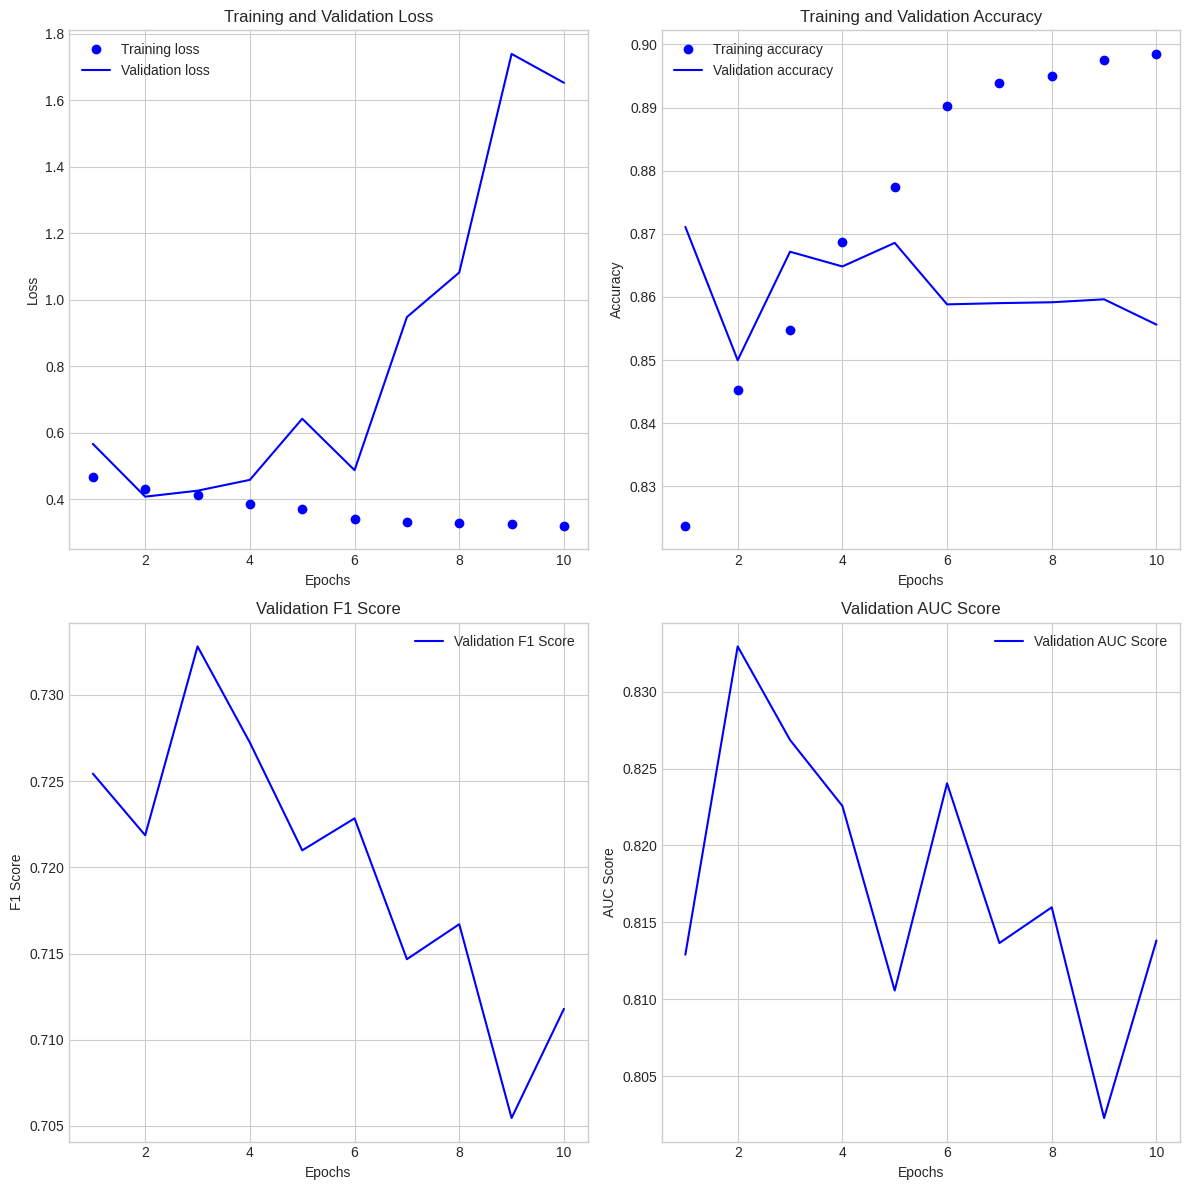

In [ ]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')

# Generate x values (epochs)
epochs = range(1, len(train_loss_data) + 1)

# Create a new figure
plt.figure(figsize=(12, 12))

# Plot training loss and accuracy
plt.subplot(2, 2, 1)
plt.plot(epochs, train_loss_data, 'bo', label='Training loss')
plt.plot(epochs, val_loss_data, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs, train_acc_data, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_data, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot validation metrics
plt.subplot(2, 2, 3)
plt.plot(epochs, val_f1_data, 'b', label='Validation F1 Score')
plt.title('Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(epochs, val_auc_data, 'b', label='Validation AUC Score')
plt.title('Validation AUC Score')
plt.xlabel('Epochs')
plt.ylabel('AUC Score')
plt.legend()

# Display the figure
plt.tight_layout()
plt.show()


# **TEST**